In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from datetime import datetime

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# He initialisation
he_init = tf.variance_scaling_initializer()

def log_dir(prefix=""):
    """Create a unique directory to save model to."""
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "./models"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

# Prepare Data

The <a href="https://arxiv.org/pdf/1812.01718.pdf">Kuzushiji-MNIST (KMNIST) dataset</a> is a drop-in replacement for the MNIST dataset (70,000 28x28 grayscale images across 10 balanced classes of Japanese Hiragana characters).

In [3]:
X_train = np.load("./Kuzushiji-MNIST/kmnist-train-imgs.npz")['arr_0']
y_train = np.load("./Kuzushiji-MNIST/kmnist-train-labels.npz")['arr_0']

X_test = np.load("./Kuzushiji-MNIST/kmnist-test-imgs.npz")['arr_0']
y_test = np.load("./Kuzushiji-MNIST/kmnist-test-labels.npz")['arr_0']

In [4]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)

X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

Plot examples of the Hiragana characters.

In [5]:
chars = pd.read_csv("./Kuzushiji-MNIST/kmnist_classmap.csv", index_col='index')
chars

,codepoint,char
index,,
0,U+304A,お
1,U+304D,き
2,U+3059,す
3,U+3064,つ
4,U+306A,な
5,U+306F,は
6,U+307E,ま
7,U+3084,や
8,U+308C,れ


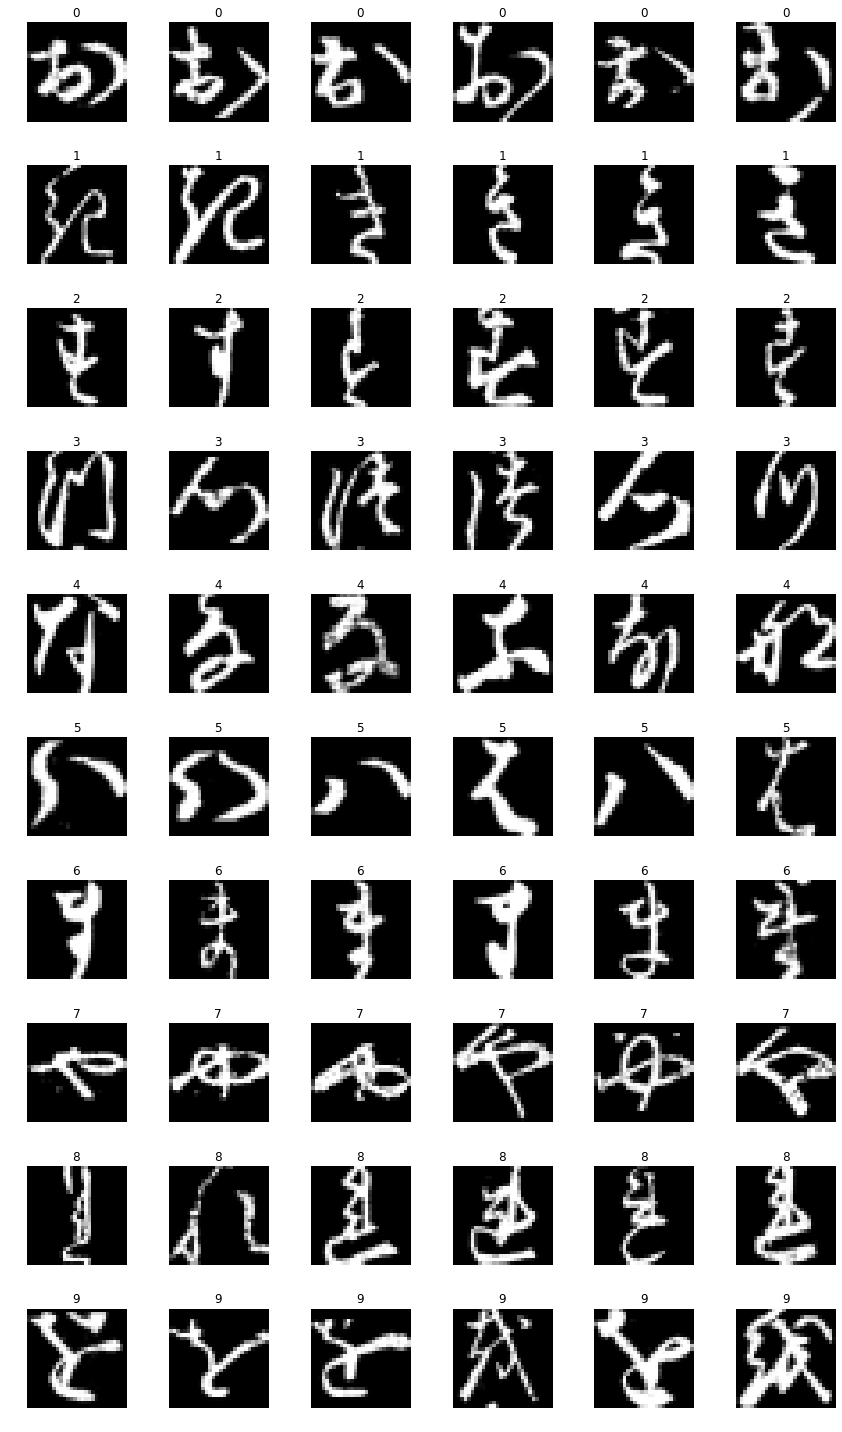

In [6]:
fig, ax = plt.subplots(10, 6, figsize=(12, 20))
for row in range(10):
    label = row
    X = X_train[y_train == label]
    y = y_train[y_train == label]
    for col in range(6):
        ax[row][col].imshow(X[col].reshape(28, 28), cmap='gray')
        ax[row][col].set_title(row)
        ax[row][col].axis('off')
plt.tight_layout()

# Prepare DNN Classifier

Create a class for a configurable DNN classifier. This is a modified version of code borrowed from <a href="https://github.com/ageron/handson-ml">Hands-on Machine Learning with Scikit-Learn and TensorFlow</a>.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None, run_name=""):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self.run_name = run_name
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")
        loss_summary = tf.summary.scalar("log_loss", loss)

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        accuracy_summary = tf.summary.scalar("accuracy", accuracy)

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._loss_summary, self._accuracy_summary = loss_summary, accuracy_summary
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            logdir = log_dir(self.run_name)
            file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph, config=config)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val, loss_str, acc_str = sess.run(
                        [self._loss, self._accuracy, self._loss_summary, self._accuracy_summary],
                         feed_dict={self._X: X_valid, self._y: y_valid})
                    file_writer.add_summary(loss_str, epoch)
                    file_writer.add_summary(acc_str, epoch)
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            save_path = self._saver.save(sess, logdir + "model.ckpt")
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

# DNN Architecture

Evaluate the performance of various DNN architectures.

In [8]:
layers = [(3, 50), (4, 50), (5, 50), (6, 50),
          (3, 100), (4, 100), (5, 100), (6, 100),
          (3, 200), (4, 200), (5, 200), (6, 200)]

In [9]:
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

layer_scores = {}

for layer in layers:
    clear_output() # Clear output between runs
    name = "%sx%s" % (layer[0], layer[1])
    print("Running %s architecture..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, n_hidden_layers=layer[0], n_neurons=layer[1], run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    layer_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", layer_scores)

Running 6x200 architecture...
0	Validation loss: 0.290601	Best loss: 0.290601	Accuracy: 91.10%
1	Validation loss: 0.219810	Best loss: 0.219810	Accuracy: 93.54%
2	Validation loss: 0.282778	Best loss: 0.219810	Accuracy: 92.00%
3	Validation loss: 0.254921	Best loss: 0.219810	Accuracy: 93.70%
4	Validation loss: 0.192018	Best loss: 0.192018	Accuracy: 95.12%
5	Validation loss: 0.191258	Best loss: 0.191258	Accuracy: 95.72%
6	Validation loss: 0.176831	Best loss: 0.176831	Accuracy: 95.80%
7	Validation loss: 0.239845	Best loss: 0.176831	Accuracy: 95.06%
8	Validation loss: 0.246536	Best loss: 0.176831	Accuracy: 95.36%
9	Validation loss: 0.219219	Best loss: 0.176831	Accuracy: 95.12%
10	Validation loss: 0.242837	Best loss: 0.176831	Accuracy: 95.12%
11	Validation loss: 0.243131	Best loss: 0.176831	Accuracy: 95.52%
12	Validation loss: 0.242219	Best loss: 0.176831	Accuracy: 95.84%
13	Validation loss: 0.249767	Best loss: 0.176831	Accuracy: 95.52%
14	Validation loss: 0.239485	Best loss: 0.176831	Accurac

# Optimisers

Evaluate the performance of various optimisers.

In [10]:
from functools import partial

momentum = partial(tf.train.MomentumOptimizer, momentum=0.9)
nesterov = partial(tf.train.MomentumOptimizer, momentum=0.9, use_nesterov=True)
rmsprop = partial(tf.train.RMSPropOptimizer, momentum=0.9, decay=0.9, epsilon=1e-10)

optimisers = [tf.train.GradientDescentOptimizer, momentum, nesterov, rmsprop,
              tf.train.AdagradOptimizer, tf.train.AdamOptimizer]
opt_names = ['GD', 'momentum', 'nesterov', 'RMSProp', 'Adagrad', 'Adam']

In [11]:
optimiser_scores = {}

for optimiser, name in zip(optimisers, opt_names):
    clear_output() # Clear output between runs
    print("Running %s optimiser..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=optimiser, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    optimiser_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", optimiser_scores)

Running Adam optimiser...
0	Validation loss: 0.268355	Best loss: 0.268355	Accuracy: 91.86%
1	Validation loss: 0.250724	Best loss: 0.250724	Accuracy: 92.40%
2	Validation loss: 0.171672	Best loss: 0.171672	Accuracy: 94.72%
3	Validation loss: 0.186867	Best loss: 0.171672	Accuracy: 94.16%
4	Validation loss: 0.188292	Best loss: 0.171672	Accuracy: 94.88%
5	Validation loss: 0.196321	Best loss: 0.171672	Accuracy: 94.62%
6	Validation loss: 0.187684	Best loss: 0.171672	Accuracy: 95.00%
7	Validation loss: 0.206910	Best loss: 0.171672	Accuracy: 95.12%
8	Validation loss: 0.216500	Best loss: 0.171672	Accuracy: 94.78%
9	Validation loss: 0.203481	Best loss: 0.171672	Accuracy: 95.16%
10	Validation loss: 0.201725	Best loss: 0.171672	Accuracy: 95.18%
11	Validation loss: 0.219731	Best loss: 0.171672	Accuracy: 95.34%
12	Validation loss: 0.201408	Best loss: 0.171672	Accuracy: 96.06%
13	Validation loss: 0.231820	Best loss: 0.171672	Accuracy: 95.28%
14	Validation loss: 0.229897	Best loss: 0.171672	Accuracy: 9

# Activation Functions

Evaluate the performance of various activation functions.

In [12]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

def selu(z, name=None,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z, name=name))

In [13]:
act_funcs = [tf.nn.relu, leaky_relu, tf.nn.elu, selu]
act_names = ['ReLU', 'leaky_ReLU', 'ELU', 'SELU']

In [14]:
act_func_scores = {}

for act_func, name in zip(act_funcs, act_names):
    clear_output() # Clear output between runs
    print("Running %s activation function..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            activation=act_func, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    act_func_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", act_func_scores)

Running SELU activation function...
0	Validation loss: 0.722715	Best loss: 0.722715	Accuracy: 78.66%
1	Validation loss: 0.600610	Best loss: 0.600610	Accuracy: 81.74%
2	Validation loss: 0.534946	Best loss: 0.534946	Accuracy: 83.84%
3	Validation loss: 0.492838	Best loss: 0.492838	Accuracy: 84.92%
4	Validation loss: 0.456516	Best loss: 0.456516	Accuracy: 86.18%
5	Validation loss: 0.423262	Best loss: 0.423262	Accuracy: 87.22%
6	Validation loss: 0.400783	Best loss: 0.400783	Accuracy: 87.80%
7	Validation loss: 0.381645	Best loss: 0.381645	Accuracy: 88.50%
8	Validation loss: 0.366205	Best loss: 0.366205	Accuracy: 88.92%
9	Validation loss: 0.354466	Best loss: 0.354466	Accuracy: 89.58%
10	Validation loss: 0.342217	Best loss: 0.342217	Accuracy: 89.88%
11	Validation loss: 0.331261	Best loss: 0.331261	Accuracy: 90.20%
12	Validation loss: 0.321830	Best loss: 0.321830	Accuracy: 90.36%
13	Validation loss: 0.315563	Best loss: 0.315563	Accuracy: 90.52%
14	Validation loss: 0.309803	Best loss: 0.309803	A

# Learning Rates

Evaluate the performance of various learning rates.

In [15]:
# Higher learning rates return errors
learning_rates = [0.001, 0.01, 0.1]

In [16]:
lr_scores = {}

for rate in learning_rates:
    clear_output() # Clear output between runs
    name = "lr_%s" % str(rate).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=rate, optimizer_class=tf.train.GradientDescentOptimizer, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    lr_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", lr_scores)

Running lr_0_1...
0	Validation loss: 0.301395	Best loss: 0.301395	Accuracy: 90.76%
1	Validation loss: 0.238603	Best loss: 0.238603	Accuracy: 92.96%
2	Validation loss: 0.204522	Best loss: 0.204522	Accuracy: 94.16%
3	Validation loss: 0.193917	Best loss: 0.193917	Accuracy: 94.76%
4	Validation loss: 0.178340	Best loss: 0.178340	Accuracy: 94.96%
5	Validation loss: 0.229832	Best loss: 0.178340	Accuracy: 94.20%
6	Validation loss: 0.194838	Best loss: 0.178340	Accuracy: 95.02%
7	Validation loss: 0.206775	Best loss: 0.178340	Accuracy: 95.12%
8	Validation loss: 0.197989	Best loss: 0.178340	Accuracy: 95.52%
9	Validation loss: 0.245215	Best loss: 0.178340	Accuracy: 94.68%
10	Validation loss: 0.250902	Best loss: 0.178340	Accuracy: 94.18%
11	Validation loss: 0.212043	Best loss: 0.178340	Accuracy: 95.86%
12	Validation loss: 0.226593	Best loss: 0.178340	Accuracy: 95.40%
13	Validation loss: 0.205906	Best loss: 0.178340	Accuracy: 95.64%
14	Validation loss: 0.241513	Best loss: 0.178340	Accuracy: 95.32%
15

# Batch Normalised Momentum

Evaluate the performance when using batch normalised momentum.

In [17]:
bnms = [None, 0.3, 0.6, 0.9]

In [18]:
bnm_scores = {}

for bnm in bnms:
    clear_output() # Clear output between runs
    name = "bnm_%s" % str(bnm).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            batch_norm_momentum=bnm, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    bnm_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", bnm_scores)

Running bnm_0_9...
0	Validation loss: 0.732450	Best loss: 0.732450	Accuracy: 78.68%
1	Validation loss: 0.559734	Best loss: 0.559734	Accuracy: 83.38%
2	Validation loss: 0.481293	Best loss: 0.481293	Accuracy: 85.74%
3	Validation loss: 0.424702	Best loss: 0.424702	Accuracy: 87.08%
4	Validation loss: 0.382907	Best loss: 0.382907	Accuracy: 88.66%
5	Validation loss: 0.354507	Best loss: 0.354507	Accuracy: 89.28%
6	Validation loss: 0.331631	Best loss: 0.331631	Accuracy: 90.26%
7	Validation loss: 0.312016	Best loss: 0.312016	Accuracy: 90.58%
8	Validation loss: 0.294791	Best loss: 0.294791	Accuracy: 91.60%
9	Validation loss: 0.282972	Best loss: 0.282972	Accuracy: 91.68%
10	Validation loss: 0.269424	Best loss: 0.269424	Accuracy: 92.12%
11	Validation loss: 0.266304	Best loss: 0.266304	Accuracy: 92.12%
12	Validation loss: 0.255991	Best loss: 0.255991	Accuracy: 92.44%
13	Validation loss: 0.245067	Best loss: 0.245067	Accuracy: 92.78%
14	Validation loss: 0.240895	Best loss: 0.240895	Accuracy: 92.86%
1

# Dropout

Evaluate the performance when using drop out.

In [19]:
dropouts = [None, 0.1, 0.3, 0.5]

In [20]:
dropout_scores = {}

for dropout in dropouts:
    clear_output() # Clear output between runs
    name = "dropout_%s" % str(dropout).replace(".", "_")
    print("Running %s..." % name)
    dnn_clf = DNNClassifier(learning_rate=0.001, optimizer_class=tf.train.GradientDescentOptimizer,
                            dropout_rate=dropout, run_name=name)
    dnn_clf.fit(X_train, y_train, n_epochs=1000, X_valid=X_valid, y_valid=y_valid)
    y_pred = dnn_clf.predict(X_test)
    dropout_scores[name] = accuracy_score(y_test, y_pred) * 100
    
print("\n", dropout_scores)

Running dropout_0_5...
0	Validation loss: 1.753258	Best loss: 1.753258	Accuracy: 43.40%
1	Validation loss: 1.492956	Best loss: 1.492956	Accuracy: 55.42%
2	Validation loss: 1.272117	Best loss: 1.272117	Accuracy: 61.76%
3	Validation loss: 1.134190	Best loss: 1.134190	Accuracy: 64.80%
4	Validation loss: 1.038231	Best loss: 1.038231	Accuracy: 67.46%
5	Validation loss: 0.968342	Best loss: 0.968342	Accuracy: 70.22%
6	Validation loss: 0.920026	Best loss: 0.920026	Accuracy: 71.62%
7	Validation loss: 0.884614	Best loss: 0.884614	Accuracy: 72.56%
8	Validation loss: 0.856531	Best loss: 0.856531	Accuracy: 73.16%
9	Validation loss: 0.831317	Best loss: 0.831317	Accuracy: 74.04%
10	Validation loss: 0.813197	Best loss: 0.813197	Accuracy: 74.62%
11	Validation loss: 0.797016	Best loss: 0.797016	Accuracy: 75.02%
12	Validation loss: 0.778424	Best loss: 0.778424	Accuracy: 75.40%
13	Validation loss: 0.758658	Best loss: 0.758658	Accuracy: 76.20%
14	Validation loss: 0.749379	Best loss: 0.749379	Accuracy: 76.8

124	Validation loss: 0.415832	Best loss: 0.415357	Accuracy: 86.92%
125	Validation loss: 0.415878	Best loss: 0.415357	Accuracy: 86.82%
126	Validation loss: 0.416444	Best loss: 0.415357	Accuracy: 86.80%
127	Validation loss: 0.414512	Best loss: 0.414512	Accuracy: 86.98%
128	Validation loss: 0.411028	Best loss: 0.411028	Accuracy: 87.18%
129	Validation loss: 0.412009	Best loss: 0.411028	Accuracy: 87.10%
130	Validation loss: 0.409801	Best loss: 0.409801	Accuracy: 87.28%
131	Validation loss: 0.408278	Best loss: 0.408278	Accuracy: 87.24%
132	Validation loss: 0.407583	Best loss: 0.407583	Accuracy: 87.22%
133	Validation loss: 0.407658	Best loss: 0.407583	Accuracy: 87.22%
134	Validation loss: 0.407731	Best loss: 0.407583	Accuracy: 87.14%
135	Validation loss: 0.406767	Best loss: 0.406767	Accuracy: 87.32%
136	Validation loss: 0.405446	Best loss: 0.405446	Accuracy: 87.38%
137	Validation loss: 0.405076	Best loss: 0.405076	Accuracy: 87.16%
138	Validation loss: 0.404473	Best loss: 0.404473	Accuracy: 87

247	Validation loss: 0.343495	Best loss: 0.343335	Accuracy: 89.44%
248	Validation loss: 0.342342	Best loss: 0.342342	Accuracy: 89.28%
249	Validation loss: 0.340980	Best loss: 0.340980	Accuracy: 89.54%
250	Validation loss: 0.343046	Best loss: 0.340980	Accuracy: 89.46%
251	Validation loss: 0.342343	Best loss: 0.340980	Accuracy: 89.66%
252	Validation loss: 0.342110	Best loss: 0.340980	Accuracy: 89.50%
253	Validation loss: 0.343415	Best loss: 0.340980	Accuracy: 89.32%
254	Validation loss: 0.339293	Best loss: 0.339293	Accuracy: 89.46%
255	Validation loss: 0.337814	Best loss: 0.337814	Accuracy: 89.60%
256	Validation loss: 0.339711	Best loss: 0.337814	Accuracy: 89.62%
257	Validation loss: 0.338538	Best loss: 0.337814	Accuracy: 89.58%
258	Validation loss: 0.337499	Best loss: 0.337499	Accuracy: 89.60%
259	Validation loss: 0.338442	Best loss: 0.337499	Accuracy: 89.54%
260	Validation loss: 0.336887	Best loss: 0.336887	Accuracy: 89.54%
261	Validation loss: 0.338527	Best loss: 0.336887	Accuracy: 89

370	Validation loss: 0.308215	Best loss: 0.308215	Accuracy: 90.62%
371	Validation loss: 0.310450	Best loss: 0.308215	Accuracy: 90.54%
372	Validation loss: 0.309223	Best loss: 0.308215	Accuracy: 90.66%
373	Validation loss: 0.308367	Best loss: 0.308215	Accuracy: 90.80%
374	Validation loss: 0.307755	Best loss: 0.307755	Accuracy: 90.64%
375	Validation loss: 0.310948	Best loss: 0.307755	Accuracy: 90.42%
376	Validation loss: 0.308868	Best loss: 0.307755	Accuracy: 90.58%
377	Validation loss: 0.307789	Best loss: 0.307755	Accuracy: 90.66%
378	Validation loss: 0.306143	Best loss: 0.306143	Accuracy: 90.94%
379	Validation loss: 0.306648	Best loss: 0.306143	Accuracy: 90.60%
380	Validation loss: 0.306080	Best loss: 0.306080	Accuracy: 90.76%
381	Validation loss: 0.307068	Best loss: 0.306080	Accuracy: 90.80%
382	Validation loss: 0.308258	Best loss: 0.306080	Accuracy: 90.62%
383	Validation loss: 0.307837	Best loss: 0.306080	Accuracy: 90.70%
384	Validation loss: 0.305640	Best loss: 0.305640	Accuracy: 90

493	Validation loss: 0.289686	Best loss: 0.287460	Accuracy: 91.44%
494	Validation loss: 0.286555	Best loss: 0.286555	Accuracy: 91.48%
495	Validation loss: 0.287958	Best loss: 0.286555	Accuracy: 91.52%
496	Validation loss: 0.287496	Best loss: 0.286555	Accuracy: 91.52%
497	Validation loss: 0.287993	Best loss: 0.286555	Accuracy: 91.46%
498	Validation loss: 0.288523	Best loss: 0.286555	Accuracy: 91.30%
499	Validation loss: 0.287765	Best loss: 0.286555	Accuracy: 91.54%
500	Validation loss: 0.288362	Best loss: 0.286555	Accuracy: 91.48%
501	Validation loss: 0.287657	Best loss: 0.286555	Accuracy: 91.48%
502	Validation loss: 0.286300	Best loss: 0.286300	Accuracy: 91.64%
503	Validation loss: 0.285632	Best loss: 0.285632	Accuracy: 91.48%
504	Validation loss: 0.287139	Best loss: 0.285632	Accuracy: 91.60%
505	Validation loss: 0.285256	Best loss: 0.285256	Accuracy: 91.46%
506	Validation loss: 0.285108	Best loss: 0.285108	Accuracy: 91.68%
507	Validation loss: 0.285074	Best loss: 0.285074	Accuracy: 91

616	Validation loss: 0.274125	Best loss: 0.274125	Accuracy: 91.82%
617	Validation loss: 0.273442	Best loss: 0.273442	Accuracy: 91.88%
618	Validation loss: 0.274041	Best loss: 0.273442	Accuracy: 91.80%
619	Validation loss: 0.272644	Best loss: 0.272644	Accuracy: 91.90%
620	Validation loss: 0.275885	Best loss: 0.272644	Accuracy: 92.04%
621	Validation loss: 0.274446	Best loss: 0.272644	Accuracy: 92.02%
622	Validation loss: 0.274155	Best loss: 0.272644	Accuracy: 91.90%
623	Validation loss: 0.274197	Best loss: 0.272644	Accuracy: 91.94%
624	Validation loss: 0.274263	Best loss: 0.272644	Accuracy: 91.96%
625	Validation loss: 0.274658	Best loss: 0.272644	Accuracy: 92.02%
626	Validation loss: 0.275207	Best loss: 0.272644	Accuracy: 91.94%
627	Validation loss: 0.273688	Best loss: 0.272644	Accuracy: 91.98%
628	Validation loss: 0.274492	Best loss: 0.272644	Accuracy: 91.84%
629	Validation loss: 0.273616	Best loss: 0.272644	Accuracy: 91.94%
630	Validation loss: 0.273622	Best loss: 0.272644	Accuracy: 91

739	Validation loss: 0.265499	Best loss: 0.264037	Accuracy: 92.16%
740	Validation loss: 0.265090	Best loss: 0.264037	Accuracy: 92.24%
741	Validation loss: 0.264816	Best loss: 0.264037	Accuracy: 92.28%
742	Validation loss: 0.266210	Best loss: 0.264037	Accuracy: 92.32%
743	Validation loss: 0.265150	Best loss: 0.264037	Accuracy: 92.14%
744	Validation loss: 0.265113	Best loss: 0.264037	Accuracy: 92.22%
745	Validation loss: 0.264858	Best loss: 0.264037	Accuracy: 92.20%
746	Validation loss: 0.263809	Best loss: 0.263809	Accuracy: 92.08%
747	Validation loss: 0.264322	Best loss: 0.263809	Accuracy: 92.12%
748	Validation loss: 0.263705	Best loss: 0.263705	Accuracy: 92.18%
749	Validation loss: 0.263969	Best loss: 0.263705	Accuracy: 92.30%
750	Validation loss: 0.263068	Best loss: 0.263068	Accuracy: 92.36%
751	Validation loss: 0.263387	Best loss: 0.263068	Accuracy: 92.36%
752	Validation loss: 0.265261	Best loss: 0.263068	Accuracy: 92.18%
753	Validation loss: 0.265381	Best loss: 0.263068	Accuracy: 92

862	Validation loss: 0.256880	Best loss: 0.255856	Accuracy: 92.46%
863	Validation loss: 0.257113	Best loss: 0.255856	Accuracy: 92.44%
864	Validation loss: 0.258292	Best loss: 0.255856	Accuracy: 92.48%
Early stopping!

 {}


# Test Results

In [34]:
print("DNN Architecture Test Scores:")
for model in layer_scores:
    #print(model, layer_scores[model])
    print("\t{0:20}{1:.2f}".format(model, layer_scores[model]))
print()
print("Optimiser Test Scores:")
for model in optimiser_scores:
    print("\t{0:20}{1:.2f}".format(model, optimiser_scores[model]))
print()
print("Activation Function Test Scores:")
for model in act_func_scores:
    print("\t{0:20}{1:.2f}".format(model, act_func_scores[model]))
print()
print("Learning Rate Test Scores:")
for model in lr_scores:
    print("\t{0:20}{1:.2f}".format(model, lr_scores[model]))
print()
print("Batch Normalised Momentum Test Scores:")
for model in bnm_scores:
    print("\t{0:20}{1:.2f}".format(model, bnm_scores[model]))
print()
print("Dropout Test Scores:")
for model in dropout_scores:
    print("\t{0:20}{1:.2f}".format(model, dropout_scores[model]))

DNN Architecture Test Scores:
	3x50                88.04
	4x50                87.47
	5x50                88.23
	6x50                87.38
	3x100               89.39
	4x100               88.57
	5x100               90.14
	6x100               88.50
	3x200               88.60
	4x200               88.88
	5x200               88.98
	6x200               90.14

Optimiser Test Scores:
	GD                  87.31
	momentum            87.70
	nesterov            88.01
	RMSProp             69.89
	Adagrad             86.83
	Adam                88.99

Activation Function Test Scores:
	ReLU                85.45
	leaky_ReLU          85.38
	ELU                 87.30
	SELU                86.74

Learning Rate Test Scores:
	lr_0_001            87.29
	lr_0_01             88.93
	lr_0_1              89.11

Batch Normalised Momentum Test Scores:
	bnm_None            86.08
	bnm_0_3             87.86
	bnm_0_6             88.88
	bnm_0_9             88.70
	dropout_0_5         82.94

Dropout Test Scores:
